# VacationPy
---

## Starter Code to Import Libraries and Load the Weather and Coordinates Data

In [6]:
# Dependencies and Setup
import hvplot.pandas
import pandas as pd

import requests
import matplotlib.pyplot as plt


import geopandas as gpd
import geoviews as gv

import numpy as np
import json


# Import API key
from api_keys import geoapify_key
from requests.structures import CaseInsensitiveDict

In [7]:
# Load the CSV file created in Part 1 into a Pandas DataFrame
city_data_df = pd.read_csv("../output_data/cities.csv")

# Display sample data
city_data_df.head()

,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,0,faya,18.3851,42.4509,22.06,35,21,2.60,SA,1666108228
1,1,farsund,58.0948,6.8047,13.30,100,0,7.65,NO,1666108228
2,2,new norfolk,-42.7826,147.0587,11.72,58,12,1.34,AU,1666108230
3,3,jamestown,42.0970,-79.2353,5.77,77,100,9.77,US,1666107934
4,4,lanzhou,36.0564,103.7922,14.53,48,59,1.20,CN,1666108230


---

### Step 1: Create a map that displays a point for every city in the `city_data_df` DataFrame. The size of the point should be the humidity in each city.

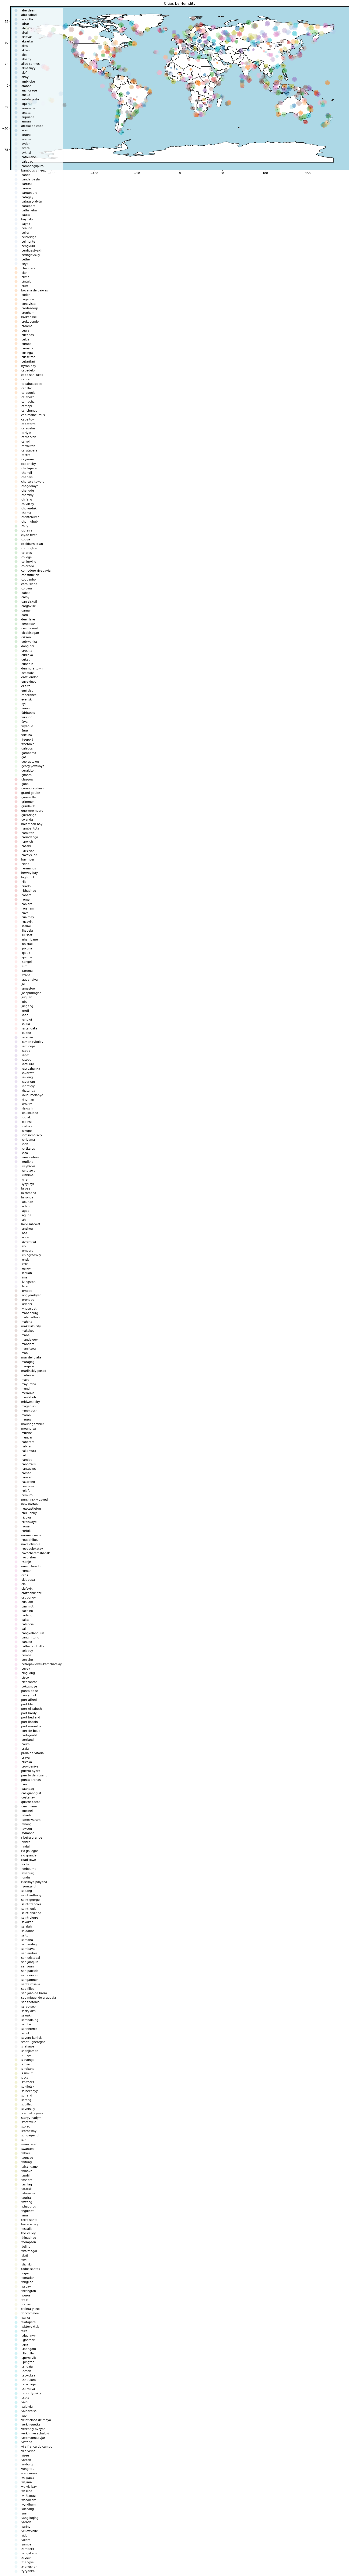

In [8]:
# Convert the data to a GeoDataFrame
city_gdf = gpd.GeoDataFrame(city_data_df, geometry=gpd.points_from_xy(city_data_df['Lng'].values, city_data_df['Lat'].values))
world_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create the map
fig, ax = plt.subplots(figsize=(30,10))
world_gdf.plot(ax=ax, color='white', edgecolor='black')

Humidity = (city_gdf['Humidity'] - city_gdf['Humidity'].min()) / (city_gdf['Humidity'].max() - city_gdf['Humidity'].min())
# Humidity level markers
city_gdf.plot(ax=ax, markersize=city_gdf['Humidity']*3, column='City', cmap='tab20', alpha=0.4, legend=True)
city_gdf.plot(ax=ax, markersize=city_gdf['Humidity']*1, column='City', cmap='tab20', alpha=0.2, legend=True, categorical=False)

plt.title('Cities by Humdity')
ax.set_facecolor('lightblue')

# Show the plot
plt.show()

### Step 2: Narrow down the `city_data_df` DataFrame to find your ideal weather condition

In [9]:

max_humidity_s = city_data_df['Humidity'] < 80
min_humidity_s = city_data_df['Humidity'] > 20

# Narrow down cities that fit criteria and drop any results with null values
comfy_city_df = city_data_df[min_humidity_s & max_humidity_s]

# Drop any rows with null values
comfy_city_df = comfy_city_df.dropna()

# Display sample data
comfy_city_df 

,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date,geometry
0,0,faya,18.3851,42.4509,22.06,35,21,2.60,SA,1666108228,POINT (42.45090 18.38510)
2,2,new norfolk,-42.7826,147.0587,11.72,58,12,1.34,AU,1666108230,POINT (147.05870 -42.78260)
3,3,jamestown,42.0970,-79.2353,5.77,77,100,9.77,US,1666107934,POINT (-79.23530 42.09700)
4,4,lanzhou,36.0564,103.7922,14.53,48,59,1.20,CN,1666108230,POINT (103.79220 36.05640)
6,6,albany,42.6001,-73.9662,10.36,74,29,2.10,US,1666108231,POINT (-73.96620 42.60010)
...,...,...,...,...,...,...,...,...,...,...,...
566,566,nhulunbuy,-12.2333,136.7667,26.34,78,88,0.00,AU,1666108559,POINT (136.76670 -12.23330)
568,568,road town,18.4167,-64.6167,31.02,70,40,4.12,VG,1666108560,POINT (-64.61670 18.41670)
574,574,canchungo,12.0672,-16.0333,35.07,61,67,2.91,GW,1666108565,POINT (-16.03330 12.06720)
575,575,iquique,-20.2208,-70.1431,17.02,68,6,3.50,CL,1666108566,POINT (-70.14310 -20.22080)


### Step 3: Create a new DataFrame called `hotel_df`.

In [10]:
# Use the Pandas copy function to create DataFrame called hotel_df to store the city, country, coordinates, and humidity
hotel_df = comfy_city_df [['City', 'Country', 'Lat', 'Lng', 'Humidity']].copy()

# Add an empty column, "Hotel Name," to the DataFrame so you can store the hotel found using the Geoapify API
hotel_df = hotel_df.assign(Hotel_Name='')

# Display sample data
hotel_df

,City,Country,Lat,Lng,Humidity,Hotel_Name
0,faya,SA,18.3851,42.4509,35,
2,new norfolk,AU,-42.7826,147.0587,58,
3,jamestown,US,42.0970,-79.2353,77,
4,lanzhou,CN,36.0564,103.7922,48,
6,albany,US,42.6001,-73.9662,74,
...,...,...,...,...,...,...
566,nhulunbuy,AU,-12.2333,136.7667,78,
568,road town,VG,18.4167,-64.6167,70,
574,canchungo,GW,12.0672,-16.0333,61,
575,iquique,CL,-20.2208,-70.1431,68,


### Step 4: For each city, use the Geoapify API to find the first hotel located within 10,000 metres of your coordinates.

In [11]:
# Set parameters to search for a hotel
geoapify_key = "e263f8b3ee9e4bca9e0b8b7ee01b9e02"
radius = 10000
params = {"q": "Hotel_Name", 
          "categories":"accommodation.hotel", 
    "radius": radius,
    "apiKey": geoapify_key}


# Print a message to follow up the hotel search
print("Starting hotel search")

# Iterate through the hotel_df DataFrame
for index, row in hotel_df.iloc[:20].iterrows():    # DEBUG-Remove iloc
    # get latitude, longitude from the DataFrame
    lat = row['Lat']
    lng = row['Lng']
    
    # Add filter and bias parameters with the current city's latitude and longitude to the params dictionary
    params["filter"] = f"circle:{lng},{lat},{radius}"
    #params["filter"] = 'withinCircle(coordinates, {}, {}, {})'.format(city_data_df["Lng"], city_data_df["Lat"], 10000)
    #params["bias"] = '{},{}'.format(city_data_df["Lng"], city_data_df["Lat"])
    params["bias"] = f"proximity:{lng},{lat}"

   # Set base URL
    base_url = "https://api.geoapify.com/v2/places"

    # Make and API request using the params dictionaty
    response = requests.get(base_url, params=params)
    
    # Convert the API response to JSON format
    name_address = response.json()
    
    # Grab the first hotel from the results and store the name in the hotel_df DataFrame
    try:
        hotel_df.loc[index, "Hotel_Name"] = name_address["features"][0]["properties"]["name"]
    except (KeyError, IndexError):
        # If no hotel is found, set the hotel name as "No hotel found".
        hotel_df.loc[index, "Hotel_Name"] = "No hotel found"
        
    # Log the search results
    print(f"{hotel_df.loc[index, 'City']} - nearest hotel: {hotel_df.loc[index, 'Hotel_Name']}")

# Display sample data
hotel_df.head(22)

Starting hotel search
faya - nearest hotel: No hotel found
new norfolk - nearest hotel: Woodbridge on the Derwent
jamestown - nearest hotel: DoubleTree Jamestown
lanzhou - nearest hotel: 西园宾馆
albany - nearest hotel: No hotel found
carnarvon - nearest hotel: No hotel found
saint-pierre - nearest hotel: Tropic Hotel
trairi - nearest hotel: Pousada Villa Aurora
qaanaaq - nearest hotel: Hotel Qaanaaq
avarua - nearest hotel: Paradise Inn
rikitea - nearest hotel: Chez Bianca & Benoit
constitucion - nearest hotel: Hostal Alameda
bambous virieux - nearest hotel: Otentic Eco Tent Experience
zangakatun - nearest hotel: No hotel found
saint-louis - nearest hotel: No hotel found
midwest city - nearest hotel: No hotel found
grimmen - nearest hotel: No hotel found
cape town - nearest hotel: Townhouse Hotel
stornoway - nearest hotel: County Hotel
naberera - nearest hotel: No hotel found


,City,Country,Lat,Lng,Humidity,Hotel_Name
0,faya,SA,18.3851,42.4509,35,No hotel found
2,new norfolk,AU,-42.7826,147.0587,58,Woodbridge on the Derwent
3,jamestown,US,42.0970,-79.2353,77,DoubleTree Jamestown
4,lanzhou,CN,36.0564,103.7922,48,西园宾馆
6,albany,US,42.6001,-73.9662,74,No hotel found
7,carnarvon,AU,-24.8667,113.6333,76,No hotel found
9,saint-pierre,RE,-21.3393,55.4781,68,Tropic Hotel
12,trairi,BR,-3.2778,-39.2689,51,Pousada Villa Aurora
14,qaanaaq,GL,77.4840,-69.3632,74,Hotel Qaanaaq
20,avarua,CK,-21.2078,-159.7750,73,Paradise Inn


### Step 5: Add the hotel name and the country as additional information in the hover message for each city in the map.

In [15]:
# Configure the map plot
map_plot = hotel_df.hvplot.points(
    "Lng", 
    "Lat", 
    geo = True, 
    size = "Humidity",
    scale = 1,
    color = "City",
    alpha = 0.5,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500,
    hover_cols = ["Hotel Name", "Country"]
)

# Display the map
map_plot

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lng,Lat]   (City,Humidity,Country)